In [2]:
# -------------------------------------------------------------------------------------
# Third party imports
# -------------------------------------------------------------------------------------
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import os, sys
import glob 
import copy

import astropy
from astropy.io import fits
from astropy.time import Time
from astropy.units import allclose as quantity_allclose
from astropy import units as u
from astropy import constants as c
from astropy.coordinates import SkyCoord
from astropy.coordinates.builtin_frames import FK5, ICRS, GCRS, GeocentricMeanEcliptic, BarycentricMeanEcliptic, HeliocentricMeanEcliptic, GeocentricTrueEcliptic, BarycentricTrueEcliptic, HeliocentricTrueEcliptic, HeliocentricEclipticIAU76
from astropy.constants import R_sun, R_earth
from astropy.nddata import CCDData
from tqdm import tnrange
from astropy.visualization import (ZScaleInterval, ImageNormalize)
from astropy.io import fits

from datetime import datetime
import copy
import numpy as np

from astropy.io import fits
from astropy import wcs
from astropy.nddata import CCDData
from ccdproc import wcs_project  # , Combiner

from matplotlib.colors import LogNorm

#from IPython.display import display, Markdown, clear_output

import inspect
import importlib
import warnings
warnings.filterwarnings('ignore')

#Import TESS Pixel Responce Function package
import PRF

# Plot setup
matplotlib.rc('font', size=22, family='serif', weight='bold')
plt.rcParams['figure.figsize'] = [10, 4]
np.printoptions(suppress=True)

In [3]:
# Local imports
sys.path.append(os.path.join(os.path.split(os.getcwd())[0], 'shifty'))
import imagehandler
import cleaner
importlib.reload(cleaner)

<module 'cleaner' from '/arc/home/mikea/Github/shifty/shifty/cleaner.py'>

In [4]:
filenames=sorted(glob.glob('/arc/home/mikea/.shifty_data/tess/5/1/4/*.fits'))[0::]

In [5]:
D=imagehandler.DataHandler(filenames[::], extno=1, EXPTIME='EXPOSURE', EXPUNIT='d', MAGZERO=18.,
                           MJD_START='BJDREFI+TSTART+-2400000.5', GAIN='GAINA', FILTER='-Tess', verbose=False)
times = np.array([dh['SHIFTY_MJD_MID'] for dh in D.image_data.header]) + 2400000.5

Reading image 1107: /arc/home/mikea/.shifty_data/tess/5/1/4/tess2018345002937-s0005-1-4-0125-s_ffic.fits
Read 1108 files!
Done!


In [6]:
import transformer
importlib.reload(transformer)

<module 'transformer' from '/arc/home/mikea/Github/shifty/shifty/transformer.py'>

%%time
time0 = times[0]                                                # Reference time

E = copy.deepcopy(D.image_data.data)
n=1000
mag_min=10
mag_max=23
cam=1
ccd=4
sector=5
eps0 = 15000  # Electrons per second of a mag 10 objects, TESS instrument Handbook
mag0 = 10     # Reference magnitude that produces eps0 electons per second

x_len = np.shape(E[0])[1]
y_len = np.shape(E[0])[0]

Transformer = transformer.Transformer(times, '500@-95', 'JPL')

# Randomize objects
x_pix0 = D.image_data.header[0]['CRPIX1']
y_pix0 = D.image_data.header[0]['CRPIX2']
radec0 = D.image_data.WCS[0].all_pix2world(x_pix0, y_pix0, 0)
latlon0 = np.array(transformer.eq_to_ec(np.radians(radec0[0]),  # Just put reference latlon at center of WCS
                                        np.radians(radec0[1]))).T
print(latlon0)

pix_scale_2d = D.image_data.WCS[0].proj_plane_pixel_scales()
pixel_scale_radians = (((pix_scale_2d[0]+pix_scale_2d[1])/2).to(u.radian)).value
npix = np.max([D.image_data.header[0]['SHIFTY_NAXIS1'], D.image_data.header[0]['SHIFTY_NAXIS2']])

alpha = (np.random.random(n) * 2.00 - 1.00 + 0.25) * npix * pixel_scale_radians  # offset in negative direction, due to motion being in positibe direction
beta = (np.random.random(n) * 1.5 - 0.75) * npix * pixel_scale_radians
gamma = np.random.random(n) * 0.15 + 0.002  # so 0.002 to 0.152, ie. distance 6.58 to 500 AU
mean_motion_circular = 2 * np.pi * gamma **1.5
speed_limit = 1.6 * mean_motion_circular  # sqrt(2) * mean_motion_circular is bound limit, doing slightly beyond in case of interstellar
adot = (np.random.random(n) * 2 - 1) * speed_limit  # from -speedlimit to +speedlimit
bdot = (np.random.random(n) * 2- 1) * speed_limit  # from -speedlimit to +speedlimit
gdot = (np.random.random(n) * 2- 1) * speed_limit  # from -speedlimit to +speedlimit
mags = np.random.random(n)**0.5 * (mag_max - mag_min) + mag_min
electronsps = eps0 * 10 ** ((mag0 - mags) / 2.5)

planted = np.zeros_like(E)
start = []
end = []
for o in np.arange(n):
    abg = (alpha[o], beta[o], gamma[o], adot[o], bdot[o], gdot[o], latlon0)
    print(o, abg, end='\r')
    shift_abg = Transformer(abg, time0, latlon0, D.image_data.WCS)
    start.append(shift_abg[0])
    end.append(shift_abg[-1])
    #print(shift_abg, np.shape(shift_abg))
    electronsps_w_noise = np.random.poisson(electronsps[o], len(E))  # Well, that's no good for faint sources
    electronsps_w_noise = np.mean(np.random.poisson(electronsps[o]*1.98, (len(E), 900))/1.98, 1)  # 1.98s is exposure time, 900 frames combined on-board before transmision.
    #that's also no good. Let's just use the exact same flux in every image for now:
    electronsps_w_noise = electronsps
    for i, d in enumerate(E):
        try:
            prf = PRF.TESS_PRF(cam, ccd, sector, shift_abg[i,1], shift_abg[i,0])
            planted[i] += prf.locate(shift_abg[i,1], shift_abg[i,0], (y_len, x_len)) * electronsps_w_noise[i]
        except ValueError:
            print(f'Oops, x or y outside usable area. {i} {o} {shift_abg[i]}', end='\r')

In [ ]:
%%time
time0 = times[0]                                                # Reference time

try:
    del E
except:
    pass
E = copy.deepcopy(D.image_data.data)
n=1000
mag_min=11
mag_max=23
cam=1
ccd=4
sector=5
eps0 = 15000  # Electrons per second of a mag 10 objects, TESS instrument Handbook
mag0 = 10     # Reference magnitude that produces eps0 electons per second

x_len = np.shape(E[0])[1]
y_len = np.shape(E[0])[0]

Transformer = transformer.Transformer(times, '500@-95', 'JPL')

# Randomize objects
x_pix0 = D.image_data.header[0]['CRPIX1']
y_pix0 = D.image_data.header[0]['CRPIX2']
radec0 = D.image_data.WCS[0].all_pix2world(x_pix0, y_pix0, 0)
latlon0 = np.array(transformer.eq_to_ec(np.radians(radec0[0]),  # Just put reference latlon at center of WCS
                                        np.radians(radec0[1]))).T
print(latlon0)

pix_scale_2d = D.image_data.WCS[0].proj_plane_pixel_scales()
pixel_scale_radians = (((pix_scale_2d[0]+pix_scale_2d[1])/2).to(u.radian)).value
npix = np.max([D.image_data.header[0]['SHIFTY_NAXIS1'], D.image_data.header[0]['SHIFTY_NAXIS2']])

alpha = (np.random.random(n) * 2.00 - 1.00 + 0.25) * npix * pixel_scale_radians  # offset in negative direction, due to motion being in positibe direction
beta = (np.random.random(n) * 1.5 - 0.75) * npix * pixel_scale_radians
gamma = np.random.random(n) * 0.15 + 0.002  # so 0.002 to 0.152, ie. distance 6.58 to 500 AU
mean_motion_circular = 2 * np.pi * gamma **1.5
speed_limit = 1.6 * mean_motion_circular  # sqrt(2) * mean_motion_circular is bound limit, doing slightly beyond in case of interstellar
adot = (np.random.random(n) * 2 - 1) * speed_limit  # from -speedlimit to +speedlimit
bdot = (np.random.random(n) * 2- 1) * speed_limit  # from -speedlimit to +speedlimit
gdot = (np.random.random(n) * 2- 1) * speed_limit  # from -speedlimit to +speedlimit
mags = np.random.random(n)**0.5 * (mag_max - mag_min) + mag_min
electronsps = eps0 * 10 ** ((mag0 - mags) / 2.5)

planted = np.zeros_like(E)
start = []
end = []
shifts = []
with open('plant_b.txt', 'w') as pfile:
    pfile.write('#Mag,electrons_ps,alpha,beta,gamma,alpha_dot,beta_dot,gamma_dot,lat0,lon0,time0,x_coo0,y_coo0,x_coo1,y_coo1,etc...\n')
    for o in np.arange(n):
        abg = (alpha[o], beta[o], gamma[o], adot[o], bdot[o], gdot[o], latlon0)
        print(o, abg, end='\r')
        shift_abg = Transformer(abg, time0, latlon0, D.image_data.WCS)
        start.append(shift_abg[0])
        end.append(shift_abg[-1])
        shifts.append(shift_abg)
        pfile.write(','.join(np.concatenate([[mags[o]], [electronsps[o]], abg[:6], latlon0, [time0], np.concatenate(shift_abg)]).astype(str))+'\n')
electronsps_w_noise = np.array([electronsps]*len(E))  # Not actually adding any noise until I figure out how to do it correctly.
print('')
for i, d in enumerate(E):
    for o in np.arange(n):
        if ((shifts[o][i,0] < 0) | (shifts[o][i,0] > x_len) | (shifts[o][i,1] < 0) | (shifts[o][i,1] > y_len)):
            continue
            #print(f'Nope, x or y outside data array. {i} {o} {shifts[o][i]}', end='\r')
        else:
            try:
                prf = PRF.TESS_PRF(cam, ccd, sector, shifts[o][i,1], shifts[o][i,0])
                planted[i] += prf.locate(shifts[o][i,1], shifts[o][i,0], (y_len, x_len)) * electronsps_w_noise[i, o]
            except ValueError:
                #print(f'Oops, x or y outside usable area. {i} {o} {shifts[o][i]}', end='\r')
                continue
    hdu = fits.PrimaryHDU(data=E[i]+planted[i], header=D.image_data.header[i])
    hdu.writeto(f'planted_b_{i:04.0f}.fits', overwrite=True)
    print(f'Saved planted_b_{i:04.0f}.fits                         ', end='\r')

[-0.20136453  1.038785  ]
999 (0.050268062163470115, 0.11245277610879172, 0.10141279802507074, -0.2580557400958026, -0.3228723456092808, 0.16363390980159898, array([-0.20136453,  1.038785  ]))  ])))))))))


(array([ 25.,  31.,  55.,  64.,  94., 117., 106., 140., 184., 184.]),
 array([11.41100949, 12.56968672, 13.72836394, 14.88704116, 16.04571839,
        17.20439561, 18.36307284, 19.52175006, 20.68042729, 21.83910451,
        22.99778173]),
 <BarContainer object of 10 artists>)

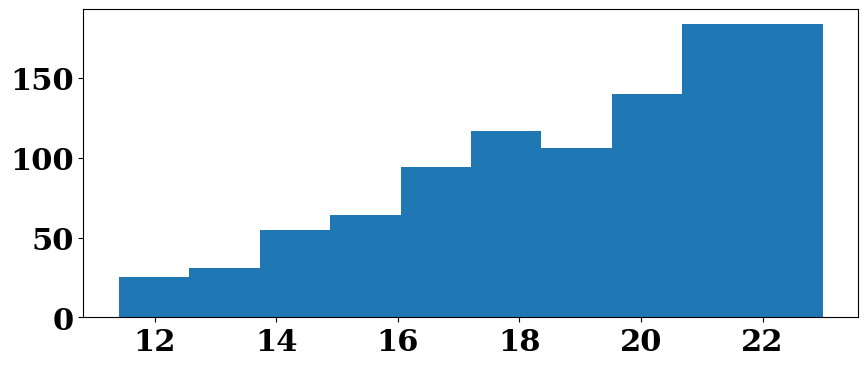

In [8]:
plt.hist(mags)

In [9]:
np.max(planted.sum(0)), np.max(E)

KeyboardInterrupt: 

In [ ]:
fig,ax = plt.subplots(1, 1, figsize=(9,9))
ax.imshow(planted.sum(0)+1e-9, norm=ImageNormalize(planted[0]+1e-9, interval=ZScaleInterval()))
ax.invert_yaxis()

In [ ]:
fig,ax = plt.subplots(1, 1, figsize=(7,7))
ax.imshow((E+planted).sum(0), norm=ImageNormalize((E+planted).sum(0)+1e-9, interval=ZScaleInterval()))
ax.invert_yaxis()

In [ ]:
fig,ax = plt.subplots(1, 1, figsize=(7,7))
ax.imshow((E).sum(0), norm=ImageNormalize((E+planted).sum(0)+1e-9, interval=ZScaleInterval()))
ax.invert_yaxis()

In [20]:
D.shifted_data.data = D.image_data.data
D.shifted_data.header = D.image_data.header
D.shifted_data.WCS = D.image_data.WCS
D.save_shifted(filename='unplant')
D.shifted_data.data = E+planted
D.shifted_data.header = D.image_data.header
D.shifted_data.WCS = D.image_data.WCS
D.save_shifted(filename='plant')

2

Done!
2

Done!


In [142]:
o=imagehandler.OneImage()
o.data=E[0]
o.header=D.image_data.header[0]
imagehandler.save_fits(o)

Saving to file data.fits

Done!


In [143]:
hdu = fits.PrimaryHDU(data=E[0], header=D.image_data.header[0])
hdu.writeto('data2.fits', overwrite=True)

In [ ]:
#plt.hist(np.array(start).T[0]-np.array(end).T[0], alpha=0.5)
plt.hist(np.array(end).T[0], alpha=0.5)
plt.hist(np.array(start).T[0], alpha=0.5)
plt.gca().axvline(0)
plt.gca().axvline(D.image_data.header[0]['NAXIS2'])

In [ ]:
#plt.hist((np.array(end).T[1]-np.array(start).T[1])[np.array(start).T[1]<0], alpha=0.5)
ybin, xbin, _ = plt.hist(np.array(end).T[1], alpha=0.5, bins=np.arange(-2000, 4000, 500))
plt.hist(np.array(start).T[1], alpha=0.5, bins=xbin)
plt.hist(np.array(start).T[1][np.array(end).T[1]>0], alpha=0.5, bins=xbin)
plt.gca().axvline(0)
plt.gca().axvline(D.image_data.header[0]['NAXIS1'])

In [ ]:
plt.hist(np.array(end).T[1]-np.array(start).T[1], alpha=0.5)
#plt.hist(, alpha=0.5)